 Fredrikson et al.'s (2015) MI-Face algorithm.

In [13]:
#pip install adversarial-robustness-toolbox

#https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/model_inversion_attacks_mnist.ipynb

In [6]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import numpy as np
from numpy.random import seed
seed(123)

from art.estimators.classification import KerasClassifier
from art.attacks.inference.model_inversion.mi_face import MIFace
from art.utils import load_dataset

%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
# Read MNIST dataset
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset(str('mnist'))

In [8]:
# create standard CNN in Keras and wrap with ART KerasClassifier:
def cnn_mnist(input_shape, min_val, max_val):
  
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    classifier = KerasClassifier(clip_values=(min_val, max_val), 
                                model=model, use_logits=False)
    return classifier

In [9]:
num_epochs = 10

# Construct and train a convolutional neural network
classifier = cnn_mnist(x_train.shape[1:], min_, max_)
classifier.fit(x_train, y_train, nb_epochs=num_epochs, batch_size=128)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 124us/sample - loss: 0.2112 - accuracy: 0.9389
Epoch 2/10
60000/60000 [==============================] - 2s 41us/sample - loss: 0.0624 - accuracy: 0.9805
Epoch 3/10
60000/60000 [==============================] - 2s 38us/sample - loss: 0.0456 - accuracy: 0.9859
Epoch 4/10
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0353 - accuracy: 0.9892
Epoch 5/10
60000/60000 [==============================] - 3s 44us/sample - loss: 0.0281 - accuracy: 0.9911
Epoch 6/10
60000/60000 [==============================] - 3s 42us/sample - loss: 0.0245 - accuracy: 0.9920
Epoch 7/10
60000/60000 [==============================] - 2s 40us/sample - loss: 0.0204 - accuracy: 0.9934
Epoch 8/10
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0179 - accuracy: 0.9939
Epoch 9/10
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0155 - accuracy: 0.9947
Epoch 10/10
6

In [16]:
# Create the attack.
# Note: by setting the threshold to 1., the attack will effectively exhaust the maximum number of iterations.

attack = MIFace(classifier, max_iter=10000, threshold=1.) 

In [17]:
# Our attack target in the following will be to infer information about the training samples 
# for each of the 10 MNIST CLASSES:

y = np.arange(10)


In [18]:
# We will experiment with a number of different initializations:

x_init_white = np.zeros((10, 28, 28, 1))
x_init_grey = np.zeros((10, 28, 28, 1)) + 0.5
x_init_black = np.ones((10, 28, 28, 1))
x_init_random = np.random.uniform(0, 1, (10, 28, 28, 1))
x_init_average = np.zeros((10, 28, 28, 1)) + np.mean(x_test, axis=0)

Initialization with White Image

In [19]:
# We observe that the classifier's gradients are vanishing on white images, therefore the attack won't work:

print("Maximum class gradient: %f" % (np.max(np.abs(classifier.class_gradient(x_init_white, y)))))

Maximum class gradient: 0.034069


Initialization with Grey Image

In [20]:

# First, we ensure that the classifier's gradients are non-vanishing for each target class:

class_gradient = classifier.class_gradient(x_init_grey, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)

print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))


Minimum over all maximum class gradient: 0.015288


In [21]:
%%time

# Now we run the attack:
x_infer_from_grey = attack.infer(x_init_grey, y)

Model inversion: 100%|██████████| 10/10 [07:51<00:00, 47.18s/it]

CPU times: total: 1min 15s
Wall time: 7min 51s


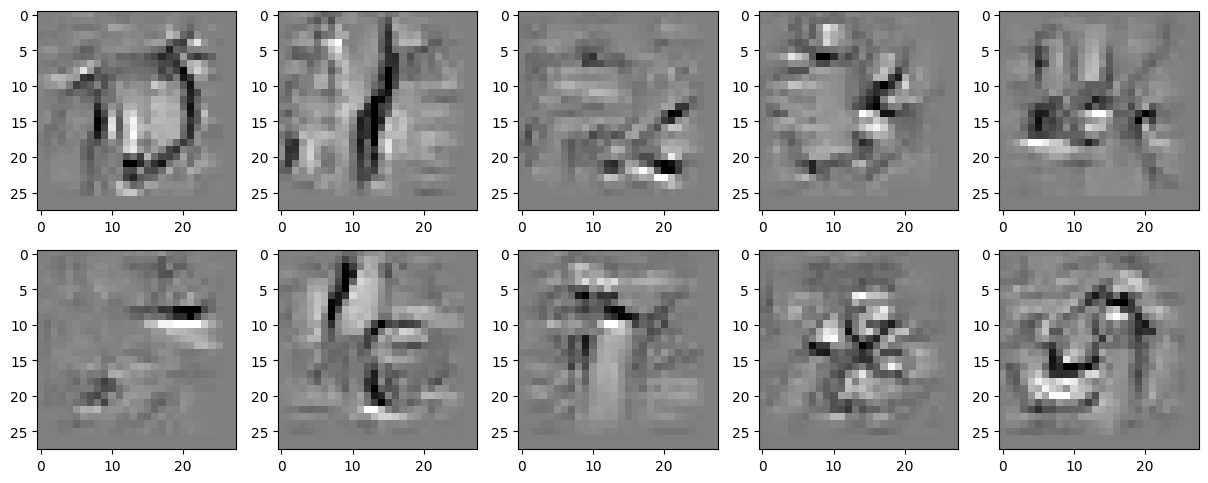

In [22]:
# Plot the inferred images:

plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_grey[0+i,], (28, 28))), cmap=plt.cm.gray_r)

Initilization with Black Image

In [23]:
# First, we ensure that the classifier's gradients are non-vanishing for each target class:

class_gradient = classifier.class_gradient(x_init_black, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)

print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))


Minimum over all maximum class gradient: 0.005665


In [24]:
%%time

# Now we run the attack:
x_infer_from_black = attack.infer(x_init_black, y)

Model inversion: 100%|██████████| 10/10 [06:30<00:00, 39.01s/it]

CPU times: total: 58.6 s
Wall time: 6min 30s


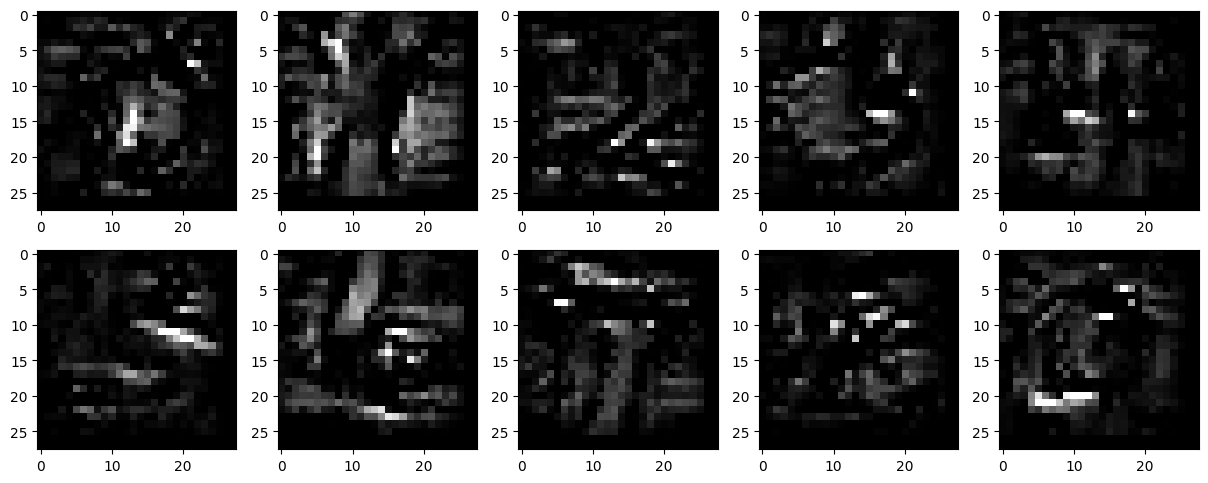

In [25]:
# Plot the inferred images:

plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_black[0+i,], (28, 28))), cmap=plt.cm.gray_r)

Initilization with Random Image

In [26]:
# First, we ensure that the classifier's gradients are non-vanishing for each target class:

class_gradient = classifier.class_gradient(x_init_random, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)

print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))

Minimum over all maximum class gradient: 0.000224


In [27]:
%%time

# Now we run the attack:
x_infer_from_random = attack.infer(x_init_random, y)

Model inversion: 100%|██████████| 10/10 [07:05<00:00, 42.54s/it]

CPU times: total: 29.7 s
Wall time: 7min 5s


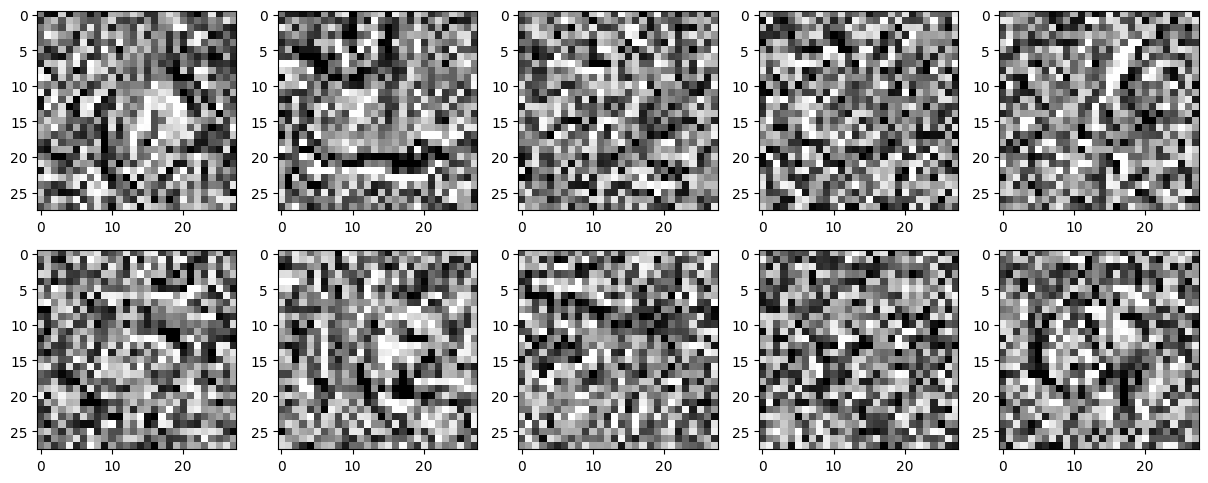

In [28]:
# Plot the inferred images:

plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_random[0+i,], (28, 28))), cmap=plt.cm.gray_r)

Initilization with average image

In [29]:
# First, we ensure that the classifier's gradients are non-vanishing for each target class:

class_gradient = classifier.class_gradient(x_init_average, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)

print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))

Minimum over all maximum class gradient: 0.010485


In [30]:
%%time

# Now we run the attack:
x_infer_from_average = attack.infer(x_init_average, y)

Model inversion: 100%|██████████| 10/10 [07:03<00:00, 42.30s/it]

CPU times: total: 28.2 s
Wall time: 7min 3s


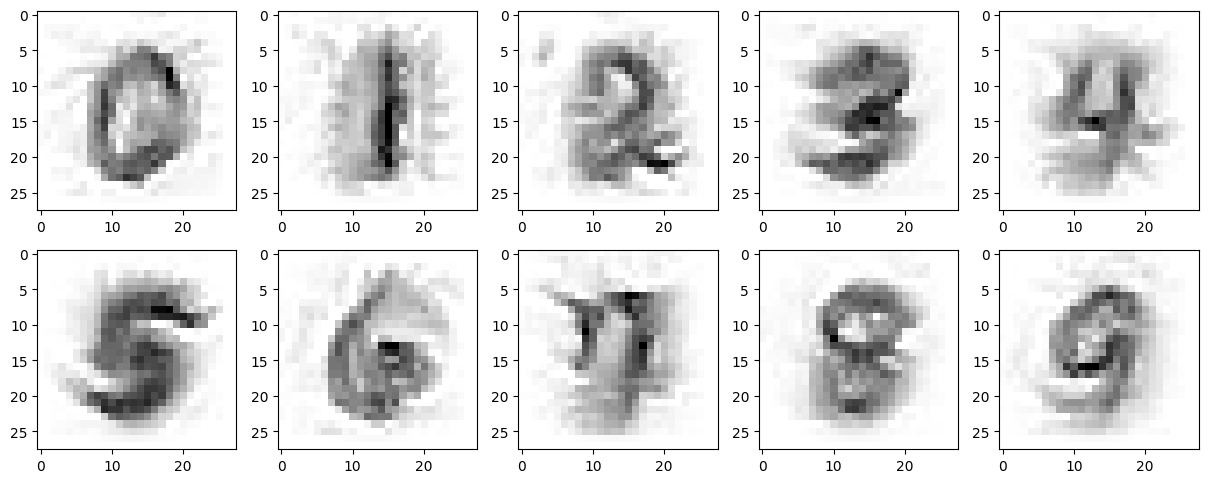

In [31]:
# Plot the inferred images:

plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_average[0+i,], (28, 28))), cmap=plt.cm.gray_r)